# Markov Chain Monte Carlo and Applications

v1.0 (2018 Spring) Tavor Baharav, Kaylee Burns, Gary Cheng, Sinho Chewi, Hemang Jangle, William Gan, Alvin Kao, Chen Meng, Vrettos Muolos, Kanaad Parvate, Ray Ramamurti, Kannan Ramchandran

## Introduction

Markov Chain Monte Carlo methods are a powerful collection of techniques that allow us to sample from a distribution _even if we can't calculate the distribution directly._ This is useful for complex models, whose distributions may be intractable to compute. The idea is that, if we are able to sample from our desired distribution, we can answer any questions we may have about that distribution.

## What is MCMC?

Our goal is to simulate a Markov chain with a state for each outcome in our probability space. If the stationary distribution of the chain matches the distribution we want to sample from, then a random walk on the chain should perform like a sequence of samples from our desired distribution.

In this lab we will be focusing on the Metropolis-Hastings algorithm, but this is not the only kind of MCMC method. Gibbs sampling, which you may have encountered in CS 188, is also a MCMC method. Gibbs sampling, however, requires computing a conditional distribution for each random variable in your model, which can be impractical and inefficient for some problems.

We'll also explore an application of our algorithm to a sneaky spy challenge: use Metropolis-Hastings to decode the secret messages Gary is sending to Tavor! 🕵️

## Developing Metropolis Hastings (MH)

Our task is to define a set of transition and acceptance probabilities so that the stationary distribution of our chain is equal to our target distribution. Recall the process for transitioning from your homework:

- Propose the next state according to a proposal distribution $f(x,\cdot)$, where $x$ is your current state.
- Accept the proposal, $y$ with probability $A(x,y) = min\{1, \frac{\pi(y)f(y,x)}{\pi(x)f(x,y)}\}$
- Only advance the state and sample upon acceptance.

In the cell below, implement Metropolis-Hastings according to the doc string. It should work for generic proposal, acceptance, and intitialization functions.

In [5]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils
import random
from super_sneaky_secret import the_secret_message

%load_ext autoreload
%autoreload 2

% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = [init_func()]
    flag = True
    for i in range(num_iters):
        candidate = proposal_func(samples[-1])
        accept_prob = acceptance_score(candidate, samples[-1])
        if random.random() < accept_prob:
            samples.append(candidate)
    return samples[::step]

## Sampling from Distributions Using MH

Now that we have a method for sampling from distributions, let's apply it to some models. We'll start with very simple models so that we can compare the results from sampling with what we can compute analytically. This is also a useful opportunity for you to debug your implementation. Your implementation should be able to model a Gaussian and exponential distribution successfully.

*An interesting fact to note is that the algorithm works even for these **continuous distributions**. In this case the underlying Markov Chain will have a continuous state space ($\mathbb{R}$)*

## A Friendly Gaussian: $\mathcal{N}(60, 1)$

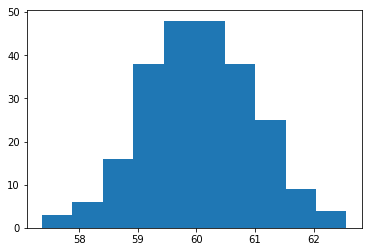

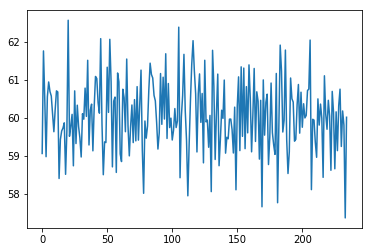

In [27]:
sample_prior = lambda: np.random.normal(loc=60)
sample_candidate = lambda theta: np.random.normal(loc=theta)
scorer = lambda x, y: (math.exp(-((x - 60)**2)/2)) / (math.exp(-((y - 60)**2)/2))
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 10000, 30)
utils.plot_histogram_and_transitions(normal_samples)

## Exponential Distribution: $\mathcal{Exp}(.5)$

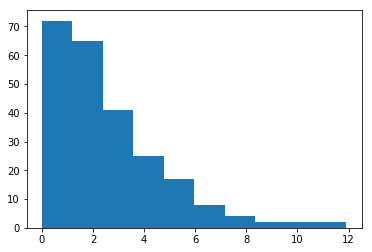

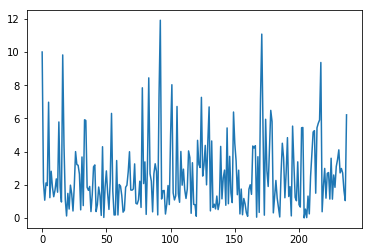

In [28]:
exp_pdf = utils.exp(0.5)
exp_scorer = lambda x,y: exp_pdf(x) / exp_pdf(y)
exp_prior = lambda : 10
exp_samples = metropolis_hastings(sample_candidate, exp_prior, exp_scorer,10000)
utils.plot_histogram_and_transitions(exp_samples)

## Effects of Initial Distribution, Convergence Diagnosis and Burn-in Time
In the case of the Gaussian above, our `init_function`(initial distribution) was $\mathcal{N}(60,1)$ which is exactly the same as the distribution we were trying to sample, i.e, we started the chain from the stationary distribution. However in general, we obviously don't have the ability to sample from the distribution we were trying to sample from in the first place! Notice that in the exponential, it goes down drastically from 10 where we started the chain, and oscillates more around lower values.

Now run the following code. As you run it, think about the following questions - are there some samples we need to ignore at the beginning? Explain what is happening with the Markov Chain based on the parameters we've used and your observations from the state vs iteration plot and tell us approximately how many samples we need to ignore.

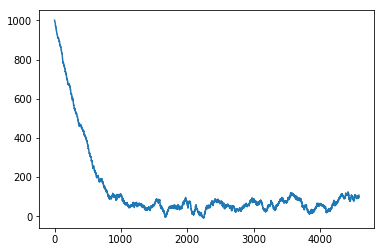

In [29]:
sample_prior = lambda: np.random.normal(loc=1000)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=3)
normal_pdf = utils.normal(60,30)
scorer = lambda x, y: normal_pdf(x)/normal_pdf(y)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

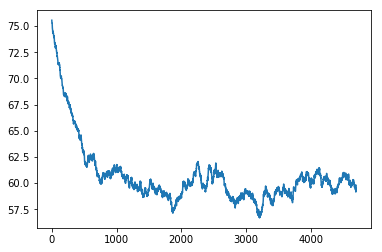

In [30]:
sample_prior = lambda: np.random.normal(loc=75)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=0.1)
normal_pdf = utils.normal(60,1)
scorer = lambda x, y: normal_pdf(x)/normal_pdf(y)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
utils.plot_transitions(normal_samples)

## YOUR ANSWER HERE

## Drawbacks of MCMC Techniques

Now we'll evaluate the effectiveness of our sampling technique on a variety of models. The examples below will highlight some of the drawbacks and idiosyncrasies of MCMC techniques. We will look at this in the context of distributions with two peaks (two separated regions of high probability), also known as bimodal distributions. We will see that the peaks may not be sampled appropriately.

## Bimodal Mixture of Gaussians

A mixture of Gaussians is obtained when you have two subpopulations ('classes') each distributed normally($\mathcal{N}(\mu_1,\sigma_1^2)$ and $\mathcal{N}(\mu_2,\sigma_2^2)$) . An example is heights of people with the subclasses of men and women. In the mixture model the 'classes' have probabilities $p$ and $1-p$ respectively. So the pdf of this distribution would be $$p\cdot f_X(x\ |\text{ class 1}) + (1-p)\cdot f_X(x\ |\text{ class 2}) = p\cdot \frac{1}{\sqrt{2\pi \sigma_1^2}} e^{-\frac{(x - \mu_1)^2}{2\sigma_1^2}} + (1-p)\cdot \frac{1}{\sqrt{2\pi \sigma_2^2}} e^{-\frac{(x - \mu_2)^2}{2\sigma_2^2}}
$$

For there to be two peaks in the pdf (to be bimodal), there should be (loosely speaking) sufficient separation between the means with respect to the standard deviations (the widths of the distributions). Otherwise if the peaks are too close relative to the widths, it is possible for the mixture to lead to just one central peak between the two means. There are exact conditions for this you can look up if you are interested. 

For this part we will be using a mixture with equal probabilities $(0.5)$ on each of the individual Gaussians with means $60$ and $40$. Try MH on this distribution for standard deviations of $5,4,3,2,1$ for each of the individual Gaussians. You should see that one of the peaks dominates (could be either one) as the standard deviation reduces even though both classes have an equal probability. For low std devs 2 and 1, only one peak should show up. What effect do you think changing the standard deviation has? What possible disadvantage of MH does this bimodal distribution show?

*Hints:* 
* *There should be jumps in your transition plots (at least for std devs 4 and 5). Think about what these jumps mean.*
* *As the widths of the peaks grow thinner, how often would you propose a state on the other peak that has a high probability?*
* *How many iterations would we need to tell that we've got samples from both classes a reasonable number of times?*

## YOUR ANSWER HERE

In [31]:
def sample_from_bimodal(stdev):
    """Samples from bimodal mixture of Gaussians
    with standard deviation stdev, as described above."""
    
    pdf = utils.gauss_mix(0.5,40,stdev,60,stdev)

    sample_candidate = lambda theta: np.random.normal(loc=theta)
    new_scorer = lambda x,y: pdf(x)/pdf(y) 
    new_prior = lambda : 50

    points = metropolis_hastings(sample_candidate,new_prior,new_scorer,10000)
    utils.plot_histogram_and_transitions(points)

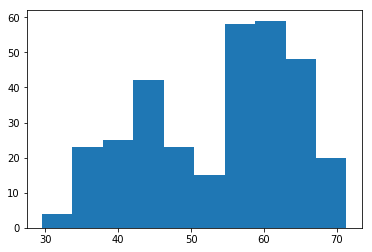

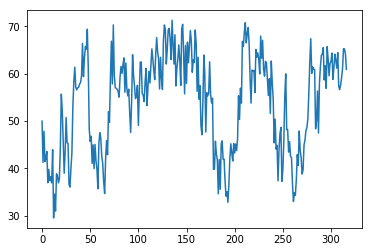

In [32]:
sample_from_bimodal(5)

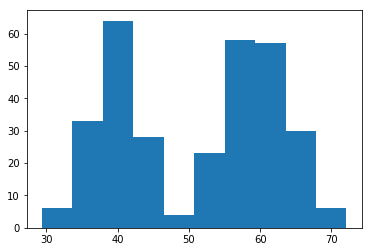

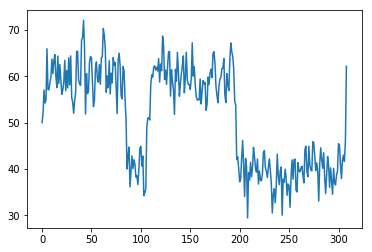

In [33]:
sample_from_bimodal(4)

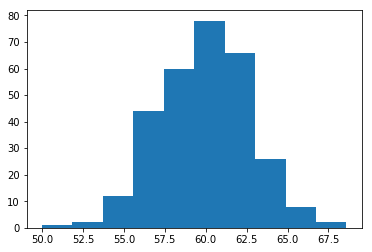

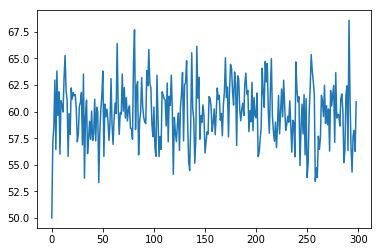

In [34]:
sample_from_bimodal(3)

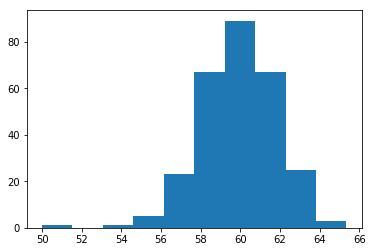

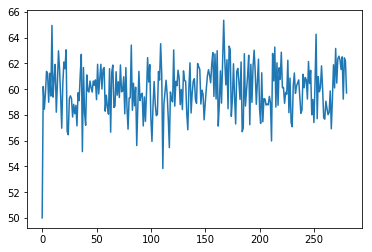

In [35]:
sample_from_bimodal(2)

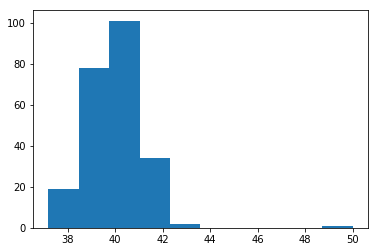

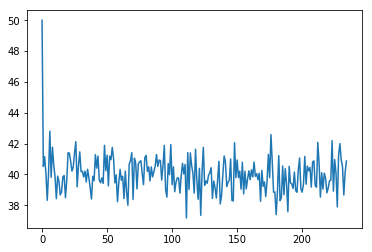

In [36]:
sample_from_bimodal(1)

## Decoding Secret Messages Using MCMC

Now we'll use our algorithm to solve a mystery on the EE 126 staff. Grumpy Gary and Tricky Tavor are sending each other secret messages using a cipher: each character in the message is either an uppercase letter or a space (27 possible characters), and their cipher is a one-to-one mapping between the letters of the alphabet + ' ', and a random permutation of the alphabet + ' '. To send a message, they replace each character with the corresponding character in their cipher.

Your job is to decode their message using the Metropolis-Hastings algorithm you wrote above. Our goal is to find the cipher that maximizes the likelihood of seeing the characters in the translated message. The cipher will be a list of integers representing the letter of the alphabet that the letter corresponding to that index should be translated to. For example, if "g" should be replaced with "a", then $\text{cipher}[6]$ should equal 0. **Note: 0-index when counting letters of the alphabet.**

Our model of language will consider each character to be dependent only on the previous character. For example,

$$P(x_1 = c, x_2 = a, x_3 = t) = P(x_1 = c)P(x_2 = a|x_1 = c)P(x_3 = t|x_2 = a)$$

These transition probabilities will be calculated empirically by counting the number of transitions between every pair of characters in a large corpus of text.

The state space is the set of all ciphers $X = \{\sigma : \sigma \text{ is a permutation of the English alphabet and '  '}\}$. $|X| = 27!$, so finding the most likely cipher is far too costly to calculate naively, but we can sample from the space of all ciphers intelligently by using Metropolis-Hastings with the following functions:

**Proposals**: To propose new ciphers, we will randomly swap two characters in our cipher.

**Acceptance Function**: Note that because our proposal distribution is symmetric, the acceptance probability becomes $A(x,y) = \frac{\widetilde{\pi}(y)}{\widetilde{\pi}(x)}$. 
$\widetilde{\pi}(x)$ is the probability of observing the sequence of characters in the message decoded by cipher $x$: 

$$\widetilde{\pi}(\cdot) = P(x_1 = \text{letter}_1)P(x_2 = \text{letter}_2|x_1 = \text{letter}_1)P(x_3 = \text{letter}_3|x_2 = \text{letter}_2)$$

$\widetilde{\pi}(\cdot)$ is _not_ a valid probability over all ciphers because we don't normalize, but it is sufficient for us to compare two ciphers.

Here is an example of one iteration of the algorithm. If we are dealing with a reduced alphabet of $\{A,B,C,D,\text{' '}\}$ and our current cipher is $[ 2,0,4,3,1 ]$, then we are mapping $A->C, B->A, C->\text{' '}$, etc. If our proposal function suggests the perturbed cipher $[ 4,0,2,3,1 ]$, we will accept this cipher as our new state with probability $\frac{\widetilde{\pi}([ 4,0,2,3,1 ])}{\widetilde{\pi}([ 2,0,4,3,1 ])}$.

We wrote functions to find the bigram frequency matrix, which gives the transition probabilities between characters, and to convert messages into a numerical format. To run the starter code below, you will need to run the `download_war_and_peace.sh` script to download corpus from which we will learn the transition probabilities. Run `./download_war_and_peace.sh` from this directory.

Some final notes and tips:
- For simplicity's sake, don't worry about the initial $P(x_1 = \text{letter}_1)$: the sequence is 538 characters long, so this initial probability won't affect the relative probability between 2 ciphers by any noticeable amount.
- To translate from letters to numbers quickly, take a look at the built-in `ord` function. Keep in mind that we are only working with uppercase letters, so it will map each letter to an integer in the range 65 to 90.

In [37]:
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

def decode(string, ordering):
    """
    Decodes a string according to the given
    ordering.
    
    ordering: a list representing the cipher.
        For example, if in our cipher, 'a'
        should be replaced with 'c', then 
        ordering[0] should equal 2.
    """
    output_str = ""
    for i in string:
        first_char = ord(i.upper()) - 65 if i.isalpha() else 26
        output_str += chr(ordering[first_char] + 65) if ordering[first_char] != 26 else " "
    return output_str

bigram_freq_matrix = build_bigram_freq_matrix(input_file)

### Visualizing the Bigram Frequency Matrix

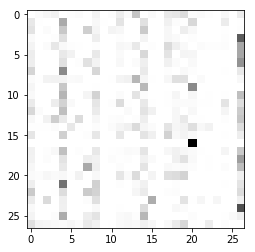

In [38]:
plt.imshow(bigram_freq_matrix, cmap='binary', interpolation='none')

In [57]:
def index(a):
    if a == ' ': return 26
    return ord(a) - ord('A')

def starting_state():
    """
    Start with a random permutation.
    """
    return np.random.permutation(list(range(27)))

def sample_candidate(sample):
    """
    To search for new ciphers, randomly
    swap two letters in the previous cipher.
    """
    sample = list(sample)
    a, b = np.random.choice(sample, 2, replace=False)
    sample[a], sample[b] = sample[b], sample[a]
    return sample

def make_acceptance_scorer(decode_string, transition_matrix):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    obseving the message translated by the current
    cipher.
    """
    def prob_of(coding):
        return prob
    
    def scorer(candidate, sample):
        nonlocal transition_matrix
        nonlocal decode_string
        decoded_c = decode(decode_string, candidate)
        decoded_s = decode(decode_string, sample)
        prob = 1
        for i in range(len(decoded_c) - 1):
            a_c, b_c = decoded_c[i], decoded_c[i+1]
            a_c, b_c = index(a_c), index(b_c)
            prob *= transition_matrix[a_c][b_c]
            
            a_s, b_s = decoded_s[i], decoded_s[i+1]
            a_s, b_s = index(a_s), index(b_s)
            prob /= transition_matrix[a_s][b_s]
    
    # TODO
        return prob
    return scorer

acceptance_scorer = make_acceptance_scorer(the_secret_message, bigram_freq_matrix)

In [67]:
# Use MCMC to find the right cipher
samples = metropolis_hastings(sample_candidate, starting_state, acceptance_scorer, 50000)

### Watch your Decoding Improve

We print out the first few samples below. As you continue to sample from the space of all ciphers, the quality of your decoding should improve roughly. You may have to run the algorithm a few times to achieve good results.

In [69]:
for sample in samples[:5]:
    print(decode(the_secret_message, sample), '\n')

XFMXMCTC TIMGZMSETMUITTBMDGCCLYWSKMXYAMVXISMGZMGYTMGZMSETFTMGIUXYWJXSWGYFMSEWFMWFMEWUEQKMGZZTYFWOTMMFGIGIWSWTFMXSMLDM TIBTQTKMCXBTMWSMSETWIMUGXQMSGMUWOTMHGCTYMXMVQXDTMSGMZTTQMDGCZGISX QTMXFMHTQQMXFM TSSTIMSETMDGCCLYWSKMMDGCVXIWYUMFVTDWZWDMEGLFTFMSGMDEXIXDSTIFMZIGCMXMCGOWTMX GLSM LQQKWYUMWFMX FLIAMXYAM TKGYAMWYXDDLIXSTMMCXBWYUMSETMDQXWCMSEXSMFGIGIWSWTFMXITMDQWPLTFMWFMATCTXYWYUMSETMFWFSTIEGGAMXYAMOXQLTFMSEXSMSETKMXITMZGLYATAMGYMMSEWFMDQTXIQKMWFMXMFSX MXSMXMDGCCLYWSKMGYMDXCVLFMSEXSMAGTFMYGSEWYUM LSMFLVVGISMSETMITFSMGZMSETMFSLATYSM GAKM 

IF I CTCLTN EY GOT SNTTX WECCRDAGH IDM KING EY EDT EY GOTFT ENSIDABIGAEDF GOAF AF OASOUH EYYTDFAVT  FENENAGATF IG RW LTNXTUTH CIXT AG GOTAN SEIU GE SAVT JECTD I KUIWT GE YTTU WECYENGILUT IF JTUU IF LTGGTN GOT WECCRDAGH  WECKINADS FKTWAYAW OERFTF GE WOINIWGTNF YNEC I CEVAT ILERG LRUUHADS AF ILFRNM IDM LTHEDM ADIWWRNIGT  CIXADS GOT WUIAC GOIG FENENAGATF INT WUAZRTF AF MTCTIDADS GOT FAFGTNOEEM IDM VIURTF GOIG GOTH INT YERDMTM ED  GOAF WUTINUH AF I FGIL IG I 

### Let's Get Sleuthy

What did Gary's secret message to Tavor say?

In [70]:
combined = [" ".join([str(x) for x in s]) for s in samples]
best_combined = max(set(combined),key=combined.count)
your_best_cipher = [int(x) for x in best_combined.split()]
decode(the_secret_message,your_best_cipher)

'AS A MEMBER OF THE GREEK COMMUNITY AND PART OF ONE OF THESE ORGANIZATIONS THIS IS HIGHLY OFFENSIVE  SORORITIES AT UC BERKELEY MAKE IT THEIR GOAL TO GIVE WOMEN A PLACE TO FEEL COMFORTABLE AS WELL AS BETTER THE COMMUNITY  COMPARING SPECIFIC HOUSES TO CHARACTERS FROM A MOVIE ABOUT BULLYING IS ABSURD AND BEYOND INACCURATE  MAKING THE CLAIM THAT SORORITIES ARE CLIQUES IS DEMEANING THE SISTERHOOD AND VALUES THAT THEY ARE FOUNDED ON  THIS CLEARLY IS A STAB AT A COMMUNITY ON CAMPUS THAT DOES NOTHING BUT SUPPORT THE REST OF THE STUDENT BODY '

### Do you recognize the message?

You may notice that sometimes when you run the algorithm, certain letters are not decoded correctly. For example, "cliques" may be translated as "clizues." Why do you think that is?

*YOUR ANSWER HERE*

[1] https://people.eecs.berkeley.edu/~sinclair/cs294/n1.pdf

[2] http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf

[3] http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf